# Pure CatBoost

In [1]:
!pip install -q catboost

In [351]:
!pip install -q optuna

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [291]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.14.3
lightgbm @ file:///tmp/lightgbm/lightgbm-4.2.0-py3-none-manylinux_2_31_x86_64.whl#sha256=26ed21477c12bb26edc4d6d51336cd43d5a8f7daf55ebbe27b0faf50ce96db23
msgpack-numpy==0.4.8
numpy @ file:///home/conda/feedstock_root/build_artifacts/numpy_1707225380409/work/dist/numpy-1.26.4-cp310-cp310-linux_x86_64.whl#sha256=51131fd8fc130cd168aecaf1bc0ea85f92e8ffebf211772ceb16ac2e7f10d7ca
pandas==2.1.4
pandas-datareader==0.10.0
pandas-profiling==3.6.6
pandas-summary==0.2.0
pandasql==0.7.3
scikit-learn==1.2.2
scikit-learn-intelex==2024.1.0
sklearn-pandas==2.2.0


## Загрузка данных

In [189]:
SEED = 42
PATH = '/kaggle/input/it-purple-hack-alpha/'
N_PATH = '/kaggle/input/new-data/'

In [190]:
train_df = pd.read_parquet(PATH + "train_data.pqt")
test_df = pd.read_parquet(PATH + "test_data.pqt")

Вытаскиваем фичи. Распределяем фичи на котег. и числ.

In [191]:
features = [col for col in train_df.columns if col not in ['date','id', 'end_cluster']]
num_feat = [col for col in features if train_df[col].dtype.name!='object']
cat_feat = [col for col in features if train_df[col].dtype.name=='object']

Заполняем пропуски в катег. фичах для работы катбуста

In [192]:
train_df[cat_feat] = train_df[cat_feat].fillna('no_data')
test_df[cat_feat] = test_df[cat_feat].fillna('no_data')

Делаем новую фичу (отрасль по оквед) 

In [193]:
def make_otrasl(okved):
    if okved == 'no_data':
        return 'no_data'
    ok = int(okved.replace("okved_",""))
    if (ok<=3):
        return "a"
    if (ok<=9):
        return "b"
    if (ok<=34):
        return "c"
    if (ok==35):
        return "d"
    if (ok<=39):
        return "e"
    if (ok<=43):
        return "f"
    if (ok<=47):
        return "g"
    if (ok<=53):
        return "h"
    if (ok<=56):
        return "i"
    if (ok<=63):
        return "j"
    if (ok<=66):
        return "k"
    if (ok==68):
        return "l"
    if (ok<=75):
        return "m"
    if (ok<=83):
        return "n"
    if (ok<=84):
        return "o"
    if (ok<=85):
        return "p"
    if (ok<=88):
        return "q"
    if (ok<=93):
        return "r"
    if (ok<=96):
        return "s"
    if (ok<=98):
        return "t"
    if (ok==99):
        return "u"
    
train_df['otrasl'] = train_df['okved'].map(lambda okved: make_otrasl(okved))
test_df['otrasl'] = test_df['okved'].map(lambda okved: make_otrasl(okved))

Меняем фичи в формат category для lgbm

In [194]:
features = [col for col in train_df.columns if col not in ['date','id', 'end_cluster']]
num_feat = [col for col in features if train_df[col].dtype.name!='object']
cat_feat = [col for col in features if train_df[col].dtype.name=='object']

In [195]:
train_df[cat_feat] = train_df[cat_feat].astype("category")
test_df[cat_feat] = test_df[cat_feat].astype("category")

<Axes: >

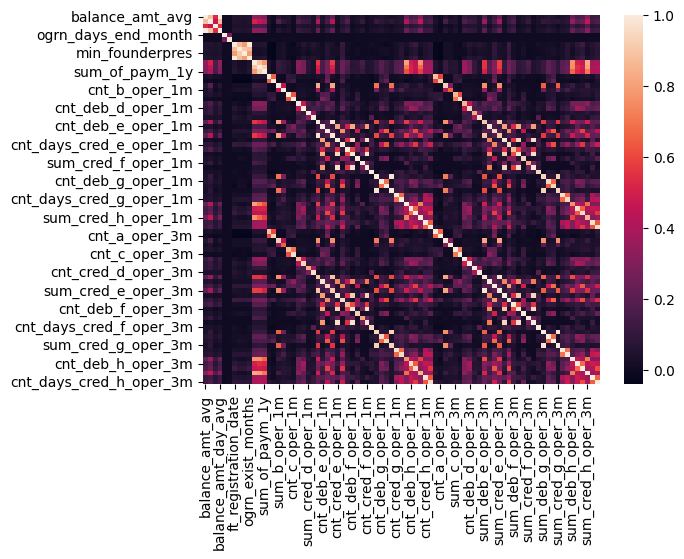

In [199]:
sns.heatmap(train_df[num_feat].corr())

Видим, что очень много коррелирующих фичей

Сделаем отбор фичей по корреляции для ускорения моделей и увеличения их стабильности

In [196]:
def feats_filter_corr(df: pd.DataFrame,
                      features: list,
                      corr_threshold: float):
    correlation_matrix = df[num_feat].corr()
    for_del_feats = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if (abs(correlation_matrix.iloc[i, j]) >= corr_threshold):
                if (df[correlation_matrix.columns[i]].isna().mean() < df[correlation_matrix.columns[j]].isna().mean()):
                    for_del_feats.add(correlation_matrix.columns[i])
                else:
                    for_del_feats.add(correlation_matrix.columns[j])

    return [feat for feat in features if feat not in for_del_feats]

features = feats_filter_corr(train_df, features, 0.95)
num_feat = [feat for feat in num_feat if feat in features]
cat_feat = [feat for feat in cat_feat if feat in features]
len(features)

69

<Axes: >

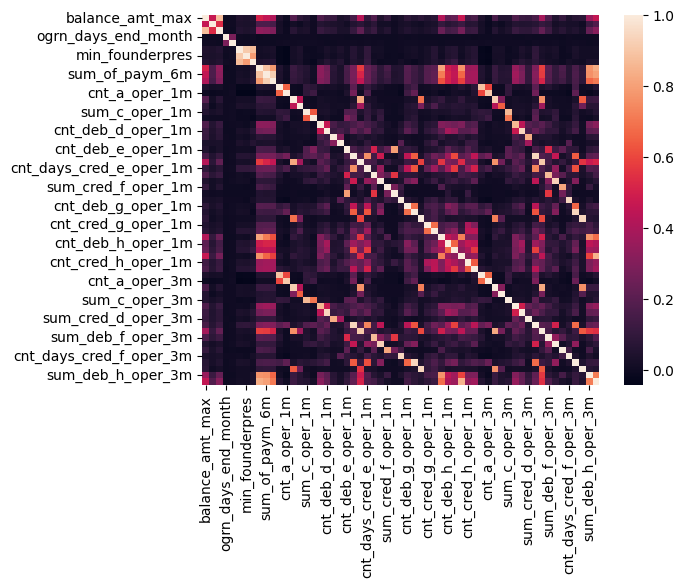

In [201]:
sns.heatmap(train_df[num_feat].corr())

# Заполним стартовые кластеры в тесте

In [111]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

date,month_4,month_5,month_6
id,,,
200000,{α},{α},no_data
200001,{α},{α},no_data
200002,{other},{other},no_data


Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>

In [321]:
train_df.pivot(index="id", columns="date", values="start_cluster").head(20)

date,month_1,month_2,month_3
id,,,
0,"{α, γ}","{α, γ}","{α, γ}"
1,{other},{other},{other}
2,{α},{α},{α}
3,{α},{α},{α}
4,{α},{α},{α}
5,{},{},{α}
6,"{α, γ}","{α, γ}","{α, γ}"
7,{α},{α},{α}
8,"{α, γ}","{α, γ}","{α, γ}"


Видим, что в большинстве случаев значение в 3 месяц равен значению в предыдущий


Покажем, что они идут друг за другом. Тогда установим, что предыдущий месяц ближайший по времени и его можно логически использовать, как лучшее приближение

In [83]:
train_df.pivot(index="id", columns="date", values="ft_registration_date").head(20)

date,month_1,month_2,month_3
id,,,
0,2.452182,2.469917,2.485936
1,0.174035,0.191770,0.207790
2,0.294178,0.311914,0.327933
3,-0.424966,-0.407230,-0.391211
4,0.409745,0.427480,0.443499
5,NaN,NaN,-1.061153
6,2.904722,2.922457,2.938476
7,1.241022,1.258758,1.274777
8,-0.033641,-0.015906,0.000113


Видим, что да, значения пройденного времени от регистрации ФНС увеличивается. Значит месяца друг за другом.


In [84]:
test_df.pivot(index="id", columns="date", values="ft_registration_date").head(20)

date,month_4,month_5,month_6
id,,,
200000,-0.653810,-0.636647,-0.618911
200001,-0.662964,-0.645800,-0.628065
200002,-0.756218,-0.739055,-0.721319
200003,-0.908400,-0.891236,-0.873501
200004,NaN,NaN,0.732416
200005,0.391437,0.408601,0.426336
200006,-0.862059,-0.844895,-0.827160
200007,1.731894,1.749057,1.766793
200008,NaN,NaN,-0.158934


Видим, что все абсолютно так же, как и в трейне, поэтому можем воспользоваться нашим способом заполнения.

В данных (и трейн, и тест) для клиента существует либо промежуток в два месяца, либо в три. Промежутки в три месяца идут подряд по времени вперед, поэтому мы берем предыдущий месяц (в трейне месяц2, а в тесте месяц5). Промежутки в два месяца существуют в тесте из-за того, что это новые клиенты, в виде (месяц5/месяц6). Опять же, скорее всего это последовательные месяца. В них во всех отсутствует информация по пройденным дням относительно регистрации ФНС, поэтому определить нельзя. Примем, их последовательными.

Посмотрим на точность подхода

In [154]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print('Precision: ', precision_score(train_df.loc[train_df['date']=='month_2']['start_cluster'],
                                     train_df.loc[train_df['date']=='month_3']['start_cluster'], average = 'macro'))
print('Recall: ', recall_score(train_df.loc[train_df['date']=='month_2']['start_cluster'],
                                     train_df.loc[train_df['date']=='month_3']['start_cluster'], average = 'macro'))
print('F1: ', f1_score(train_df.loc[train_df['date']=='month_2']['start_cluster'],
                                     train_df.loc[train_df['date']=='month_3']['start_cluster'], average = 'macro'))

Precision:  0.8437222203860811
Recall:  0.8380542237341007
F1:  0.8353206667314569


Попробуем улучшить с помощью модели catboost

In [175]:
st_train_df = train_df.drop(['end_cluster'],axis=1).copy()
st_test_df = test_df.copy()

In [176]:
X_st_test = st_test_df.loc[st_test_df['date'] == 'month_6'].copy()
X_st_test['pred_clust'] = st_test_df.loc[st_test_df['date'] == 'month_5']['start_cluster'].values

In [177]:
X_st = st_train_df.loc[st_train_df['date'] == 'month_3'].copy()

In [178]:
X_st['pred_clust'] = st_train_df.loc[st_train_df['date'] == 'month_2']['start_cluster'].values.astype("category")

In [179]:
features_for_st = [col for col in X_st.columns if col not in ['date','id', 'start_cluster', 'end_cluster']]
num_feat_for_st = [col for col in features_for_st if X_st[col].dtype.name!='category']
cat_feat_for_st = [col for col in features_for_st if X_st[col].dtype.name=='category']
len(features_for_st)

91

In [180]:
def feats_filter_corr(df: pd.DataFrame,
                      features: list,
                      corr_threshold: float):
    correlation_matrix = df[num_feat_for_st].corr()
    for_del_feats = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if (abs(correlation_matrix.iloc[i, j]) >= corr_threshold):
                if (df[correlation_matrix.columns[i]].isna().mean() < df[correlation_matrix.columns[j]].isna().mean()):
                    for_del_feats.add(correlation_matrix.columns[i])
                else:
                    for_del_feats.add(correlation_matrix.columns[j])

    return [feat for feat in features if feat not in for_del_feats]

features_for_st = feats_filter_corr(X_st, features_for_st, 0.95)
num_feat_for_st = [feat for feat in num_feat_for_st if feat in features_for_st]
cat_feat_for_st = [feat for feat in cat_feat_for_st if feat in features_for_st]
len(features_for_st)

66

In [ ]:
X_st_cl = X_st[features_for_st]
y_st_cl = X_st['start_cluster']

In [ ]:
X_train_st, X_val_st, y_train_st, y_val_st = train_test_split(
    X_st_cl,
    X_st['start_cluster'],
    test_size=0.2,
    random_state=SEED
)

In [161]:
st_simple_model = CatBoostClassifier(iterations = 1500, random_state = SEED, task_type="GPU", verbose=500,
                                     loss_function = 'MultiClass', cat_features=cat_feat_for_st)
st_simple_model.fit(X_train_st, y_train_st)

Learning rate set to 0.136461
0:	learn: 1.2961054	total: 48.1ms	remaining: 1m 12s
500:	learn: 0.2082598	total: 14.5s	remaining: 29s
1000:	learn: 0.1867041	total: 29.9s	remaining: 14.9s
1499:	learn: 0.1669327	total: 44.9s	remaining: 0us


In [182]:
preds = st_simple_model.predict(X_val_st)

In [163]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print('Precision: ', precision_score(preds, y_val_st, average = 'macro'))
print('Recall: ', recall_score(preds, y_val_st, average = 'macro'))
print('F1: ', f1_score(preds, y_val_st, average = 'macro'))

Precision:  0.8975299837596834
Recall:  0.9439974886777198
F1:  0.9181053469726357


In [181]:
pd.DataFrame({'col': st_simple_model.feature_names_,
                  'importance': st_simple_model.get_feature_importance()}).sort_values('importance', ascending=False)

,col,importance
65,pred_clust,24.380062
14,okved,4.659135
0,balance_amt_max,4.418866
3,channel_code,4.074626
1,balance_amt_min,3.999699
...,...,...
21,sum_b_oper_1m,0.067181
41,cnt_cred_g_oper_1m,0.065814
42,cnt_days_cred_g_oper_1m,0.048043
37,cnt_days_cred_f_oper_1m,0.027617


Видим увеличение точности. Оставляем этот вариант

In [ ]:
st_simple_model.fit(X_st_cl, y_st_cl)

In [184]:
X_test_cl = X_st_test[features_for_st]

In [185]:
test_preds = st_simple_model.predict(X_test_cl)

In [186]:
test_preds = [x[0] for x in test_preds]

Заполняем стартовый кластер тестовой выборки

In [187]:
X_month_6 = test_df.loc[test_df['date'] == 'month_6'].copy()
X_month_6['start_cluster'] = test_preds
X_month_6[cat_feat] = X_month_6[cat_feat].astype("category")

## Обучение модели

Разделим трейн-выборку на обучающую и валидационную

In [197]:
X = train_df[features]
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

Попробуем базовые фичи

In [219]:
model = CatBoostClassifier(iterations = 10000, random_state = SEED, task_type="GPU", verbose=500,
                           loss_function = 'MultiClass', cat_features=cat_feat)
model.fit(x_train,y_train)

Learning rate set to 0.035158
0:	learn: 2.5497423	total: 84.9ms	remaining: 14m 8s
500:	learn: 0.8264995	total: 28.3s	remaining: 8m 56s
1000:	learn: 0.8036156	total: 54.8s	remaining: 8m 12s
1500:	learn: 0.7883158	total: 1m 20s	remaining: 7m 38s
2000:	learn: 0.7755308	total: 1m 46s	remaining: 7m 7s
2500:	learn: 0.7635327	total: 2m 13s	remaining: 6m 39s
3000:	learn: 0.7519841	total: 2m 39s	remaining: 6m 12s
3500:	learn: 0.7412196	total: 3m 6s	remaining: 5m 45s
4000:	learn: 0.7304883	total: 3m 33s	remaining: 5m 19s
4500:	learn: 0.7206119	total: 4m	remaining: 4m 53s
5000:	learn: 0.7108922	total: 4m 27s	remaining: 4m 26s
5500:	learn: 0.7013551	total: 4m 54s	remaining: 4m
6000:	learn: 0.6926813	total: 5m 21s	remaining: 3m 34s
6500:	learn: 0.6838946	total: 5m 49s	remaining: 3m 7s
7000:	learn: 0.6756779	total: 6m 16s	remaining: 2m 41s
7500:	learn: 0.6674847	total: 6m 43s	remaining: 2m 14s
8000:	learn: 0.6593566	total: 7m 11s	remaining: 1m 47s
8500:	learn: 0.6517321	total: 7m 38s	remaining: 1m 2

Зададим функцию для взвешенной метрики roc auc

In [58]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

Вытащим веса из файла

In [59]:
cluster_weights = pd.read_excel(PATH + "cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [181]:
y_pred_proba = model.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9571957511488558

Оптуной вытащили лучшие параметры

In [399]:
n_best_params = {'task_type': 'GPU',
                'devices':'0:1',
                'loss_function': 'MultiClass',
                'iterations': 5000,
                'depth': 8,
                'learning_rate': 0.09988525267381272,
                'l2_leaf_reg': 3,
                'min_data_in_leaf': 3,
                'random_state': SEED,
                'bootstrap_type': 'Bayesian',
                'bagging_temperature': 1.9577543519618354}

Обучим новую модель

In [411]:
n_model = CatBoostClassifier(**n_best_params, verbose=500, cat_features=cat_feat)
n_model.fit(X,y)

0:	learn: 2.0468806	total: 138ms	remaining: 11m 28s
500:	learn: 0.7481154	total: 45.6s	remaining: 6m 49s
1000:	learn: 0.6814379	total: 1m 31s	remaining: 6m 5s
1500:	learn: 0.6250709	total: 2m 18s	remaining: 5m 22s
2000:	learn: 0.5765829	total: 3m 6s	remaining: 4m 38s
2500:	learn: 0.5352393	total: 3m 54s	remaining: 3m 54s
3000:	learn: 0.4998708	total: 4m 42s	remaining: 3m 8s
3500:	learn: 0.4693999	total: 5m 31s	remaining: 2m 21s
4000:	learn: 0.4416856	total: 6m 20s	remaining: 1m 35s
4500:	learn: 0.4181472	total: 7m 9s	remaining: 47.6s
4999:	learn: 0.3971660	total: 7m 58s	remaining: 0us


In [402]:
y_pred_proba = n_model.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, n_model.classes_, weights_dict)

0.9592160816867515

## Прогноз на тестовой выборке

Закидываем фичи для обучения

In [198]:
final_test_df = X_month_6[features]

Здесь вместо model можно написать best_model для использования фичей, найденных оптуной

In [201]:
test_pred_proba = model.predict_proba(final_test_df[features])
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

Сохраняем результат

In [25]:
sample_submission_df = pd.read_csv(PATH+"sample_submission.csv")
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("cats20_submission.csv", index=False)

Здесь то же самое, только обучаем LGBMClassifier на найденных гиперпараметрах

In [53]:
lgb_best_params = {
    'lambda_l1': 0.35653021324357753,
    'lambda_l2': 4.511066289639228,
    'num_leaves': 248,
    'feature_fraction': 0.8615168473264664,
    'bagging_fraction': 0.933596143137619,
    'bagging_freq': 1,
    'min_child_samples': 65
}

In [65]:
best_model = LGBMClassifier(**lgb_best_params, n_estimators = 350, verbosity=-1, random_state=42, n_jobs=-1)
best_model.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.933596143137619, bagging_freq=1,
               feature_fraction=0.8615168473264664,
               lambda_l1=0.35653021324357753, lambda_l2=4.511066289639228,
               min_child_samples=65, n_estimators=350, n_jobs=-1,
               num_leaves=248, random_state=42, verbosity=-1)

In [64]:
y_pred_proba = best_model.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, best_model.classes_, weights_dict)

0.9971412313579274

Предикт и сохранение соотвественно

In [67]:
test_pred_proba = best_model.predict_proba(final_test_df[features])
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=best_model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [68]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("cats_my_submission.csv", index=False)

# Усреднение предсказаний

Обобщим все разные получившиеся результаты от разных моделей с разными гипер-ми путем высчитывания среднего значения

In [11]:
PPATH = '/kaggle/input/predds/'

In [12]:
pred_1 = pd.read_csv(PPATH+'1.csv')
pred_2 = pd.read_csv(PPATH+'2.csv')
pred_3 = pd.read_csv(PPATH+'3.csv')
pred_4 = pd.read_csv(PPATH+'4.csv')
pred_5 = pd.read_csv(PPATH+'5.csv')
pred_6 = pd.read_csv(PPATH+'6.csv')

In [13]:
predlgb_1 = pd.read_csv('/kaggle/input/lgbpreds/43b798bc-74bc-4c86-8ae7-e4cb09034ff7.csv')
predlgb_2 = pd.read_csv('/kaggle/input/lgbpreds/8358422c-59be-40c7-b7a8-3e2a3fb66d21.csv')
predlgb_3 = pd.read_csv('/kaggle/input/lgbpreds/b5c0b1fc-1d57-4cfd-a6b2-d1c6076f06bd.csv')
predlgb_4 = pd.read_csv('/kaggle/input/lgbpreds/d042d66c-21b6-40b0-bf51-7aa1accacf81.csv')
predlgb_5 = pd.read_csv('/kaggle/input/new-preds/cats45_submission (1).csv')
predlgb_6 = pd.read_csv('/kaggle/input/new-preds/cats_my_submission.csv')
predlgb_7 = pd.read_csv('/kaggle/input/new-preds/59a590f8-c688-4ca9-b15c-9a9ef1ccb4a0.csv')

In [41]:
new_cat1 = pd.read_csv('/kaggle/input/light-new/cats_my_submission.csv')
new_cat2 = pd.read_csv('/kaggle/input/light-new/cats_my_submission1.csv')
new_cat3 = pd.read_csv('/kaggle/input/light-new/cats_my_submission2.csv')

In [42]:
pred_sun = pred_6.copy()

In [57]:
cats = [x for x in pred_sun.columns if x not in ["id"]]
for cat in cats:
    pred_sun[cat] = (pred_1[cat]+pred_2[cat]+pred_3[cat]+pred_4[cat]+pred_5[cat]+pred_6[cat]+predlgb_1[cat]+predlgb_2[cat]+predlgb_3[cat]+predlgb_4[cat]+predlgb_5[cat]+predlgb_6[cat]+new_cat1[cat]+new_cat2[cat])/14

In [58]:
pred_sun.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.005614,0.013731,0.033098,0.013889,0.002911,0.000040,0.000324,0.000044,0.011138,0.002258,0.007010,0.000074,0.000769,2.386929e-06,0.002013,0.907076,9.111331e-06
1,200001,0.003181,0.586150,0.000097,0.000348,0.000069,0.000025,0.000014,0.000003,0.000392,0.008492,0.000111,0.000030,0.000146,2.765581e-07,0.000138,0.400792,1.152979e-05
2,200002,0.758321,0.000928,0.001166,0.047074,0.005830,0.000287,0.000306,0.002159,0.019262,0.013622,0.003676,0.003583,0.000475,9.345981e-06,0.034419,0.108829,5.294859e-05
3,200003,0.024035,0.655157,0.000190,0.000233,0.000050,0.000095,0.000025,0.000036,0.000128,0.021231,0.003215,0.000016,0.000254,4.138983e-07,0.000039,0.295297,3.655907e-07
4,200004,0.047385,0.137742,0.005940,0.019998,0.000797,0.000123,0.000049,0.000026,0.002344,0.115779,0.004124,0.000086,0.002391,9.001613e-07,0.000101,0.663109,2.602550e-06


Сохраняем результат

In [59]:
pred_sun.to_csv("subm10.csv", index=False)